# Домашнее задание 3: Imitation Learning (Behavioral Cloning и DAgger)

В этом задании вы познакомитесь с методами **имитационного обучения (Imitation Learning)** — подходом к обучению агентов, при котором они учатся напрямую копировать поведение эксперта, не получая при этом явного сигнала награды от среды. Такие методы особенно полезны, когда:
- награда разрежена или недоступна,
- экспертное поведение легко продемонстрировать, но трудно формализовать,
- требуется быстро получить рабочую политику без длительного взаимодействия со средой.

Вы реализуете два ключевых алгоритма:
1. **Behavioral Cloning (BC)** — простейший метод, сводящийся к задаче регрессии: по состоянию предсказать действие эксперта.
2. **DAgger (Dataset Aggregation)** — итеративный метод, который решает проблему *covariate shift*, активно собирая опыт в тех состояниях, куда попадает обучаемая политика.

## План задания и распределение баллов

| Этап | Описание | Максимум баллов |
|------|---------|------------------|
| **1. Оценка эксперта** | Оценка производительности предобученного эксперта (жадная и стохастическая политики), реализация IQM и визуализация поведения | **3 балла** |
| **2. Сбор датасета** | Генерация датасета траекторий от эксперта и сохранение в HDF5 | **2 балла** |
| **3. Behavioral Cloning** | Реализация нейросетевой архитектуры, обучение BC и оценка качества | **5 баллов**<br>— 2 балла за `MLPBlock`<br>— 2 балла за `MLPActHead`<br>— 1 балл за обучение и оценку |
| **4. Анализ BC** | Исследование зависимости качества BC от размера датасета с использованием IQM и сравнением in/out-of-distribution оценок | **5 баллов** |
| **5. DAgger** | Реализация итеративного алгоритма DAgger, сбор новых данных с участием эксперта и анализ сходимости | **5 баллов** |
| **Итого** | | **20 баллов** |

> 💡 **Совет**: начните с малых экспериментов (например, 10 траекторий) для отладки, и только затем масштабируйтесь до полного датасета (1024 траектории). Это сэкономит время и ресурсы Colab.

Удачи!

## Установка среды

In [ ]:
import os
os.environ["MUJOCO_GL"] = "egl"
os.environ["PYOPENGL_PLATFORM"] = "egl"

# import os
# if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
#     !bash xvfb start
#     os.environ['DISPLAY'] = ':1'

!pip install dm_control>=1.0.34  #torch==2.2.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install shimmy[dm-control]
!pip install gymnasium
!pip install torchinfo

# import warnings; warnings.filterwarnings(action="ignore", message=r"datetime.datetime.utcnow")
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="pkg_resources")
warnings.filterwarnings("ignore", message="datetime.datetime.utcnow")

## Проверка установки и рендеринг среды MuJoCo  
Убедитесь, что среда корректно установлена и можно получить изображения из неё.


In [ ]:
import gymnasium as gym
import numpy as np
from dm_control import suite
from dm_control.suite.wrappers import pixels
from shimmy import DmControlCompatibilityV0

warnings.filterwarnings(action="ignore", message=r"datetime.datetime.utcnow")

### Обёртка для рендеринга в средах DeepMind Control Suite  
Поскольку оригинальная среда `dm_control` не предоставляет метод `.render()` в формате, совместимом с Gymnasium, мы создаём собственную обёртку `DmControlWithRender`.  
Эта обёртка добавляет метод `render()`, который использует встроенный рендерер MuJoCo для получения изображений заданного разрешения и с нужной камеры.

In [ ]:
class DmControlWithRender(gym.Wrapper):
    def __init__(self, env, height=84, width=84, camera_id=0):
        super().__init__(env)
        self._height = height
        self._width = width
        self._camera_id = camera_id

    def render(self):
        # Access the underlying dm_control env
        dm_env = self.unwrapped._env
        return dm_env.physics.render(
            height=self._height,
            width=self._width,
            camera_id=self._camera_id
        )

### Фабрика среды (`make_env`)  
Функция `make_env` создаёт настраиваемую среду с поддержкой различных полезных обёрток из Gymnasium:

- **`domain`, `task`** — определяют конкретную задачу (например, `"cheetah"` / `"run"`).
- **`frame_stack`** — количество последовательных наблюдений, объединяемых в одно состояние (полезно при обучении на изображениях или для учёта динамики).
- **`flatten_frames`** — если включено, наблюдения (даже стекированные) преобразуются в одномерный вектор.
- **`render_enabled`** — добавляет возможность рендеринга через обёртку `DmControlWithRender`.
- **`record_stats`** — включает сбор статистики по эпизодам (награда, длина и т.д.).
- **`transform_reward`** — применяет нормализацию и ограничение награды (использовалось при обучении эксперта).
- **`hw`** — высота и ширина изображения при рендеринге. Рекомендуется использовать небольшие значения (например, 64) для ускорения работы; максимальное разрешение — 480×480.

Эта функция возвращает *thunk* — callable без аргументов, который создаёт и возвращает готовую среду. Такой подход удобен при векторизации сред (например, через `gym.vector.SyncVectorEnv`).

In [ ]:
def make_env(
        domain,
        task,
        frame_stack=1,
        flatten_frames=True,
        render_enabled=True,
        record_stats=False,
        transform_reward=False,
        gamma=0.99,
        hw=64,
    ):
    def thunk():
        dm_env = suite.load(
            domain_name=domain,
            task_name=task,
            task_kwargs=None,
            environment_kwargs=None,
            visualize_reward=False,
        )
        env = DmControlCompatibilityV0(dm_env)
        env = gym.wrappers.FlattenObservation(env) # dict obs -> vector

        # Only add render method if needed (doesn't affect obs)
        if render_enabled:
            env = DmControlWithRender(env, height=hw, width=hw)

        # Observation is always numeric state → consistent!
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            env = gym.wrappers.DtypeObservation(env, np.float32)
        if record_stats:
          env = gym.wrappers.RecordEpisodeStatistics(env)
        env = gym.wrappers.ClipAction(env)
        if transform_reward:
          env = gym.wrappers.NormalizeReward(env, gamma=gamma)
          env = gym.wrappers.TransformReward(env, lambda r: np.clip(r, -10, 10))

        # if frame_stack > 1:
        env = gym.wrappers.FrameStackObservation(env, stack_size=frame_stack)
        if flatten_frames:
            env = gym.wrappers.FlattenObservation(env)
        return env
    return thunk

**Инициализация среды**

Чтобы создать **одну** среду, достаточно вызвать фабричную функцию `make_env` и сразу же выполнить возвращаемый *thunk*:

```python
env = make_env(domain="cheetah", task="run", ...)()
```

Этот вызов создаёт экземпляр среды с заданными параметрами и готов к использованию: можно вызывать `env.reset()`, `env.step(action)` и т.д.

**Немного о векторизованных средах**  (`SyncVectorEnv`)

Однако при обучении агентов (особенно с помощью методов типа PPO или A2C) часто требуется **параллельно взаимодействовать с несколькими копиями среды**. Это позволяет:
- ускорить сбор данных за счёт параллелизма,
- уменьшить корреляцию между последовательными наблюдениями,
- стабилизировать обучение за счёт более разнообразного опыта.

Для этого в Gymnasium предусмотрен класс `SyncVectorEnv`, который объединяет несколько независимых сред в один векторизованный объект. Пример:

```python
from gymnasium.vector import SyncVectorEnv

num_envs = 4
envs = SyncVectorEnv([
    make_env(domain="cheetah", task="run", ...)
    for _ in range(num_envs)
])
```

Теперь `envs` ведёт себя как единая среда, но на самом деле управляет `num_envs` независимыми инстансами:
- `envs.reset()` возвращает массив наблюдений формы `(num_envs, obs_dim)`,
- `envs.step(actions)` принимает массив действий формы `(num_envs, act_dim)` и возвращает соответствующие награды, следующие состояния и флаги завершения.

Важно: `SyncVectorEnv` работает **синхронно** — все среды выполняются последовательно в основном потоке. Для настоящего параллелизма (в отдельных процессах) можно использовать `AsyncVectorEnv`, но для большинства учебных и прототипных задач `SyncVectorEnv` более чем достаточно и проще в отладке.

Этот подход используется, например, при загрузке эксперта: даже если нужна всего одна среда, её всё равно удобно оборачивать в `SyncVectorEnv`, чтобы архитектура агента (`Agent`) могла работать с батчами наблюдений (`envs.single_observation_space` и `envs.single_action_space` дают доступ к пространству одной среды).

In [ ]:
# Cоздайте среду для задачи cheetah run
env = make_env(domain="cheetah", task="run")()

In [ ]:
env.observation_space

Box(-inf, inf, (17,), float32)

In [ ]:
env.action_space

Box(-inf, inf, (6,), float64)

In [ ]:
env.reset()

(array([-0.08786006,  0.02373837, -0.07293124, -0.02814104, -0.09779148,
         0.00791026,  0.01214426,  0.02966995, -0.01888457, -0.01181677,
         0.01691848, -0.0159064 ,  0.0019057 , -0.03410456, -0.00050905,
        -0.07229132, -0.09131008], dtype=float32),
 {'timestep.discount': None, 'timestep.step_type': <StepType.FIRST: 0>})

array([[[ 67, 100, 134],
        [ 67, 100, 134],
        [ 69, 102, 136],
        ...,
        [ 68, 101, 135],
        [ 70, 103, 136],
        [ 67, 101, 135]],

       [[ 66, 100, 133],
        [ 66, 100, 133],
        [ 66, 100, 134],
        ...,
        [ 68, 101, 134],
        [ 67, 101, 134],
        [ 66, 100, 133]],

       [[ 66,  99, 133],
        [ 66,  99, 133],
        [ 66, 100, 133],
        ...,
        [ 72, 104, 137],
        [ 67, 100, 133],
        [ 67, 100, 133]],

       ...,

       [[ 36,  54,  72],
        [ 36,  54,  72],
        [ 38,  56,  74],
        ...,
        [ 39,  56,  74],
        [ 36,  54,  72],
        [ 38,  56,  73]],

       [[ 35,  53,  70],
        [ 35,  53,  70],
        [ 36,  53,  71],
        ...,
        [ 36,  53,  71],
        [ 35,  53,  71],
        [ 36,  54,  71]],

       [[ 36,  54,  71],
        [ 35,  52,  70],
        [ 35,  52,  70],
        ...,
        [ 39,  57,  74],
        [ 36,  53,  71],
        [ 35,  52,  70]]], dtype=uint8)
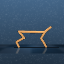

In [ ]:
env.render()

Среда **MuJoCo** (в рамках DeepMind Control Suite) предоставляет множество различных задач, каждая из которых может рендериться с разных камер и имеет свои особенности динамики. Например:

- `walker / walk` — двуногий ходячий робот, обучающийся устойчиво передвигаться;
- `hopper / hop` — одноногий прыгающий агент;
- `cartpole / balance` — классическая задача балансировки на тележке;
- `reacher / easy` — манипулятор, который должен дотянуться до цели;
- `finger / spin` — задача вращения объекта с помощью двухпалого захвата;
- `cheetah / run` — четвероногий робот-гепард, обучающийся бегу вперёд.

Все эти среды поддерживают рендеринг с разных точек зрения (камер), что позволяет визуализировать поведение агента под разными углами. Однако для данного домашнего задания мы будем использовать только одну задачу — **`cheetah / run`**, так как именно для неё предоставлен экспертный агент и датасет.

## Загрузка экспертного агента

Загружаем предобученного эксперта — агента, обученного с помощью PPO.  

Для работы с этим заданием рекомендуется:

1. [Скачать папку](https://drive.google.com/drive/folders/1KAHb73CbOvmtGLKFVOHPUjQ44tFy74Mw?usp=sharing) с весами и конфигурацией к себе на **Google Диск**. В этой папке вы можете найти чекпоинты для 3х сред: `cheetah-run`, `hopper-hop` и `walker-run`, однако для этого задания нам понадобятся только `cheetah-run`.
2. Подключить Google Диск к среде Colab.


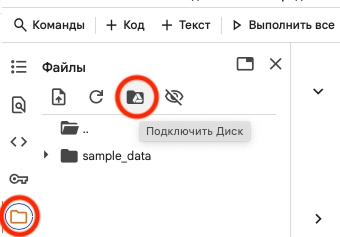

3. Убедиться, что путь `checkpoint_path` указывает на правильное расположение файлов `config.pt` и `checkpoint.pt`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ls "/content/drive/MyDrive/path-2-your-cheetah-folder/"

checkpoint.pt  config.pt


In [ ]:
checkpoint_path = "/content/drive/MyDrive/path-2-your-cheetah-folder/"
config_name = "config.pt"
checkpoint_name = "checkpoint.pt"

### Вспомогательные функции для нормализации наблюдений

Для стабильного обучения и оценки политик в RL часто используется **нормализация наблюдений** — приведение входных данных к нулевому среднему и единичной дисперсии.  
Класс `RunningMeanStd` реализует **онлайн-оценку среднего и дисперсии** по приходящим батчам данных, используя **параллельный алгоритм обновления моментов**.

Этот подход позволяет:
- эффективно обновлять статистики без хранения всей истории,
- корректно объединять статистики из разных источников (например, при распределённом сборе данных),
- избежать численной нестабильности, связанной с наивным подсчётом дисперсии.

In [ ]:
import torch
import torch.nn as nn
from torch.distributions.normal import Normal

def update_mean_var_count_from_moments(mean, var, count, batch_mean, batch_var, batch_count):
    """Updates the mean, var and count using the previous mean, var, count and batch values."""
    delta = batch_mean - mean
    tot_count = count + batch_count

    new_mean = mean + delta * batch_count / tot_count
    m_a = var * count
    m_b = batch_var * batch_count
    M2 = m_a + m_b + torch.square(delta) * count * batch_count / tot_count
    new_var = M2 / tot_count
    new_count = tot_count

    return new_mean, new_var, new_count


class RunningMeanStd(nn.Module):
    """Tracks the mean, variance and count of values."""

    # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
    def __init__(self, shape=(), epsilon=1e-4, dtype=torch.float32):
        super().__init__()
        """Tracks the mean, variance and count of values."""
        self.register_buffer("mean", torch.zeros(shape, dtype=dtype))
        self.register_buffer("var", torch.zeros(shape, dtype=dtype))
        self.register_buffer("count", torch.as_tensor(epsilon, dtype=dtype))

    def update(self, x):
        """Updates the mean, var and count from a batch of samples."""
        batch_mean = torch.mean(x, dim=0)
        batch_var = torch.var(x, dim=0)
        batch_count = x.shape[0]
        self.__update_from_moments(batch_mean, batch_var, batch_count)

    def __update_from_moments(self, batch_mean, batch_var, batch_count):
        """Updates from batch mean, variance and count moments."""
        self.mean, self.var, self.count = update_mean_var_count_from_moments(
            self.mean, self.var, self.count, batch_mean, batch_var, batch_count
        )

### Архитектура агента

Агент состоит из двух нейросетей:
- **Актёр (`actor_mean`)** — предсказывает среднее значение действия в виде гауссовой политики.
- **Критик (`critic`)** — оценивает ценность (value) текущего состояния.

Особенности:
- Используется **ортогональная инициализация весов** (`layer_init`).
- Логарифм стандартного отклонения (`actor_logstd`) обучается как глобальный параметр (не зависит от состояния).
- Наблюдения **нормализуются онлайн** с помощью `RunningMeanStd`.
- Для совместимости с Gymnasium и векторизованными средами агент принимает среду типа `SyncVectorEnv`, но работает и с одной средой. При инициализации в него нужно подать такую среду.

Метод `act_numpy` позволяет удобно вызывать агента из NumPy-кода (например, при сборе траекторий).

In [ ]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


class Agent(nn.Module):
    def __init__(self, envs, hidden_dim=64, obs_norm_eps=1e-8):
        super().__init__()
        input_dim = np.array(envs.single_observation_space.shape).prod()

        self.obs_rms = RunningMeanStd(input_dim)
        self.obs_norm_eps = obs_norm_eps

        self.critic = nn.Sequential(
            layer_init(nn.Linear(input_dim, hidden_dim)),
            nn.Tanh(),
            layer_init(nn.Linear(hidden_dim, hidden_dim)),
            nn.Tanh(),
            layer_init(nn.Linear(hidden_dim, 1), std=1.0),
        )
        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(input_dim, hidden_dim)),
            nn.Tanh(),
            layer_init(nn.Linear(hidden_dim, hidden_dim)),
            nn.Tanh(),
            layer_init(nn.Linear(hidden_dim, np.prod(envs.single_action_space.shape)), std=0.01),
        )
        self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(envs.single_action_space.shape)))

    def update_obs_rms(self, x):
        self.obs_rms.update(x)

    def normalize_obs(self, x):
        normalized_obs = (x - self.obs_rms.mean) / torch.sqrt(self.obs_rms.var + self.obs_norm_eps)
        # const taken from the cleanrl
        normalized_obs = torch.clamp(normalized_obs, -10, 10)
        return normalized_obs

    def get_value(self, x):
        return self.critic(self.normalize_obs(x))

    def get_action_and_value(self, x, action=None, greedy=False):
        value = self.critic(self.normalize_obs(x))

        action_mean = self.actor_mean(self.normalize_obs(x))
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            if greedy:
                action = action_mean.detach()
            else:
                action = probs.sample()

        return action, probs.log_prob(action).sum(1), probs.entropy().sum(1), value

    def act_numpy(self, obs, greedy=False):
        obs = torch.tensor(obs[None], device=next(self.parameters()).device)
        action = self.get_action_and_value(obs, greedy=greedy)[0].cpu()
        action = np.asarray(action.squeeze())
        return action


### Функция загрузки эксперта

Функция `load_expert` выполняет следующие шаги:
1. Загружает конфигурацию (`config.pt`), чтобы узнать архитектурные параметры (например, `hidden_dim`) и задачу (`domain`, `task`).
2. Создаёт **одну среду** через `SyncVectorEnv` (это необходимо, потому что агент ожидает векторизованный интерфейс).
3. Инициализирует агент с правильной архитектурой и загружает сохранённые веса (`checkpoint.pt`).
4. Перемещает модель на CPU или GPU в зависимости от флага `use_cuda`.

Это стандартный пайплайн загрузки моделей в RL, особенно при использовании библиотек вроде CleanRL.

In [ ]:
def load_expert(use_cuda = False):
    device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")

    config = torch.load(os.path.join(checkpoint_path, config_name))
    checkpoint = torch.load(
        os.path.join(checkpoint_path, checkpoint_name), map_location=device
    )
    domain, task = config['domain'], config['task']
    print(f"Loaded chekpoint for {domain} {task} from {os.path.join(checkpoint_path, checkpoint_name)}")

    init_env = gym.vector.SyncVectorEnv([make_env(domain, task) for i in range(1)])

    agent = Agent(init_env, hidden_dim=config["hidden_dim"]).to(device)
    agent.load_state_dict(checkpoint)
    print(f"Agent is loaded!")
    return agent

### Загружаем эксперта

Здесь мы фактически вызываем функцию `load_expert(False)`, чтобы загрузить экспертного агента на CPU (это достаточно для оценки и сбора данных).  
После выполнения этой ячейки переменная `expert` содержит полностью рабочую модель, готовую к использованию в последующих этапах задания: оценке, сбору датасета и имитационному обучению.

In [ ]:
expert = load_expert(False)

Loaded chekpoint for cheetah run from /content/drive/MyDrive/path-2-your-cheetah-folder/checkpoint.pt
Agent is loaded!


## Evaluate expert (3 балла)

В этом разделе вам предстоит **оценить производительность загруженного экспертного агента** и **визуализировать его поведение** в виде анимации (GIF/видео). За выполнение этого задания вы получите до **3 баллов**:

- **1 балл** — за оценку средней награды при использовании **жадной (deterministic)** политики (`greedy=True`) и **стохастической (stochastic)** политики (`greedy=False`);
- **1 балл** — за реализацию iqm оценки награды для обоих вариантов политик (жадной и стохастической);
- **1 балл** — за генерацию и отображение корректной анимации поведения эксперта для обоих вариантов политик (жадной и стохастической)

> ⚠️ **Важно**: используйте фиксированный `seed` в функции `env.reset` (например, `seed=0`) для воспроизводимости результатов. Это критично как для оценки, так и для проверки.

### Сбор траектории без рендеринга (для оценки награды) 1 балл

Ниже приведён пример кода, который собирает одну траекторию с использованием **стохастической** политики.  
**Ваша задача** — запустить аналогичные оценки **для обоих режимов** (`greedy=True` и `greedy=False`) и вывести среднюю награду за эпизод.

> 💡 Совет: вы можете обернуть этот код в функцию, чтобы избежать дублирования.

In [ ]:
from tqdm import trange

@torch.no_grad()
def eval_expert(agent, is_greedy=False, seed=0, num_episodes=1):

    # инициализация среды
    env = make_env(domain="cheetah", task="run", render_enabled=False)()

    eval_returns = []
    for idx in trange(num_episodes):
        traj_return = 0.0

        obs, _ = env.reset(seed=seed + idx) # фиксируем сид
        done = False
        while not done:

            #### ВАШ КОД ####
            # оцените traj_return (суммарную награду агента за эпизод)
            action = agent.act_numpy(obs, greedy=is_greedy)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            traj_return += reward
            #### ВАШ КОД ####

        eval_returns.append(traj_return)
    return eval_returns

In [ ]:
# Оценка жадной политики
greedy_returns = eval_expert(expert, is_greedy=True, seed=0, num_episodes=50)
print(f"\nGreedy return: {np.mean(greedy_returns):.1f} ± {np.std(greedy_returns):.1f}\n")

# Оценка стохастической политики
stochastic_returns = eval_expert(expert, is_greedy=False, seed=0, num_episodes=50)
print(f"\nStochastic return: {np.mean(stochastic_returns):.1f} ± {np.std(stochastic_returns):.1f}\n")

100%|██████████| 50/50 [00:55<00:00,  1.12s/it]



Greedy return: 829.2 ± 64.0



100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


Stochastic return: 821.6 ± 29.8



Опишите полученные результаты (сравните полученные mean и std для различных варинтов политик) Предположите, почему получились такие результаты. Порассуждайте на тему того, сколько эпизодов необходимо для стабильной оценки.

... ВАШ ТЕКСТ ...

На основе полученных результатов:

Жадная политика (Greedy return: 829.2 ± 64.0) показывает немного более высокую среднюю награду по сравнению со стохастической (Stochastic return: 821.6 ± 29.8). Однако, стандартное отклонение для жадной политики значительно выше (64.0 против 29.8).

Это может быть связано с тем, что жадная политика всегда выбирает действие с наибольшей предсказанной ценностью, что делает ее более детерминированной и потенциально более чувствительной к начальным состояниям или небольшим вариациям среды. В некоторых эпизодах это может привести к очень высоким наградам, но в других - к более низким, если выбранное действие окажется неоптимальным в долгосрочной перспективе из-за отсутствия исследования.

Стохастическая политика, вводя элемент случайности в выбор действия, может лучше исследовать пространство состояний и действий, что приводит к более стабильным результатам со значительно меньшим стандартным отклонением. Она может избегать попадания в локальные оптимумы или проблемные состояния, которые могут возникать при полностью детерминированном поведении. Хотя средняя награда немного ниже, ее консистентность выше.

Для стабильной оценки производительности агента количество эпизодов зависит от вариабельности среды и самой политики. В данном случае, даже при 50 эпизодах, мы видим довольно существенное стандартное отклонение, особенно у жадной политики. Для более надежной оценки, особенно в задачах с высокой стохастичностью или сложной динамикой, может потребоваться от нескольких сотен до тысяч эпизодов. Использование таких метрик, как IQM (которые мы рассмотрим далее), также помогает получить более
устойчивую оценку, игнорируя выбросы.

### Реализация iqm (более стабильной оценки награды) 1 балл

[IQM (Interquartile Mean)](https://www.statisticshowto.com/interquartile-mean-iqm-midmean/) — это среднее значение, вычисленное только по центральным 50% данных (между 25-м и 75-м перцентилями). Он устойчив к экстремальным значениям и часто используется в RL-бенчмарках (например, в работах DeepMind и в NeurIPS competitions).

Реализуйте две функции:

* iqm(scores) — возвращает среднее по интерквартильному диапазону;
* iqm_std(scores) — возвращает стандартное отклонение внутри этого диапазона (не по всем данным!).


In [ ]:
from typing import Union, List
import numpy as np

def iqm(scores: Union[np.ndarray, List]):
    """Вычисляет среднее по интерквартильному диапазону (25–75 перцентили)."""

    #### ВАШ КОД ####
    scores = np.asarray(scores)
    q1 = np.percentile(scores, 25)
    q3 = np.percentile(scores, 75)
    iqm_scores = scores[(scores >= q1) & (scores <= q3)]
    iqm_score = np.mean(iqm_scores)
    #### ВАШ КОД ####

    return iqm_score

def iqm_std(scores: Union[np.ndarray, List]):
    """Вычисляет стандартное отклонение по интерквартильному диапазону."""
    #### ВАШ КОД ####
    scores = np.asarray(scores)
    q1 = np.percentile(scores, 25)
    q3 = np.percentile(scores, 75)
    iqm_scores = scores[(scores >= q1) & (scores <= q3)]
    iqm_std_score = np.std(iqm_scores)

    return iqm_std_score

In [ ]:
scores = list(range(4))
assert iqm(scores) == 1.5 and round(iqm_std(scores), 2) == 0.5, "Smth is wrong"
scores = list(range(45))
assert iqm(scores) == 22. and round(iqm_std(scores), 2) == 6.63, "Smth is wrong"
scores = [4, 2, 3, 0, 1, 1, -1, 27, -10000]
assert iqm(scores) == 1.4 and round(iqm_std(scores), 2) == 1.02, "Smth is wrong"
print("iqm and iqm_std seems fine :)")

iqm and iqm_std seems fine :)


In [ ]:
# Оценка жадной политики c помощью iqm
print(f"Greedy return: {iqm(greedy_returns):.1f} ± {iqm_std(greedy_returns):.1f}")

# Оценка стохастической политики c помощью iqm
print(f"Stochastic return: {iqm(stochastic_returns):.1f} ± {iqm_std(stochastic_returns):.1f}")

Greedy return: 843.1 ± 5.3
Stochastic return: 826.2 ± 7.2


Опишите полученные результаты (сравните полученные iqm/iqm_std оценки с классическими mean/std). Какие вы видите плюсы и минусы у тех и других оценок?

... ВАШ ТЕКСТ ...

Опишите полученные результаты (сравните полученные iqm/iqm_std оценки с классическими mean/std). Какие вы видите плюсы и минусы у тех и других оценок?

На основе полученных IQM/IQM_std оценок:

Жадная политика (Greedy return: 843.1 ± 5.3) и стохастическая политика (Stochastic return: 826.2 ± 7.2) показывают более близкие средние значения по сравнению с классическими mean/std оценками (829.2 ± 64.0 и 821.6 ± 29.8 соответственно). Самое заметное отличие — значительно меньшее стандартное отклонение при использовании IQM.

Плюсы IQM/IQM_std:
- **Устойчивость к выбросам**: IQM игнорирует 25% самых низких и 25% самых высоких значений, что делает его менее чувствительным к аномально хорошим или плохим эпизодам. Это особенно полезно в средах с высокой вариабельностью или при наличии редких "удачных" или "неудачных" траекторий.
- **Более стабильная оценка**: Меньшее стандартное отклонение IQM_std указывает на то, что оценка среднего значения в центральном диапазоне более стабильна и менее подвержена влиянию крайних значений.

Минусы IQM/IQM_std:
- **Потеря информации**: Игнорирование крайних значений означает потерю некоторой информации о полном распределении наград. В некоторых случаях, именно экстремальные значения могут быть важны для понимания потенциала или рисков политики.
- **Интерпретация**: Классическое среднее и стандартное отклонение более интуитивно понятны и широко используются, что упрощает сравнение с другими работами или бенчмарками, где IQM не применяется.

Плюсы Mean/Std:
- **Учитывает все данные**: Mean и Std используют все доступные данные, предоставляя полную картину распределения наград.
- **Стандартная метрика**: Широко используются и легко интерпретируются.

Минусы Mean/Std:
- **Чувствительность к выбросам**: Сильно подвержены влиянию экстремальных значений, что может искажать представление о типичной производительности политики.
- **Высокое стандартное отклонение**: В средах с высокой вариабельностью стандартное отклонение может быть очень большим, что затрудняет сравнение политик и оценку статистической значимости различий.

В данном случае, IQM/IQM_std оценки дают более уверенное представление о "типичной" производительности эксперта в центральном диапазоне, в то время как Mean/Std показывают более широкий разброс результатов, включая потенциальные выбросы. Для оценки стабильности и надёжности политики, IQM является предпочтительной метрикой, как и принято в современных RL бенчмарках.

### Сбор траектории с рендерингом (для визуализации)


Чтобы создать анимацию, нужно собрать последовательность кадров (`frames`) с помощью `env.render()`.  

> ⚠️ **Важно**: среда должна быть создана с `render_enabled=True` (по умолчанию в `make_env` это так).


In [ ]:
from tqdm import trange

@torch.no_grad()
def log_expert_frames(agent, is_greedy=False, seed=0):

    # инициализация среды
    env = make_env(domain="cheetah", task="run", render_enabled=True)()

    frames = []
    traj_return = 0.0

    obs, _ = env.reset(seed=seed) # фиксируем сид
    done = False
    while not done:

        #### ВАШ КОД ####
        # заполните список картиночных наблюдений в среде с помощью env.render()
        # также оцените traj_return (суммарную награду агента за эпизод)
        frames.append(env.render())
        action = agent.act_numpy(obs, greedy=is_greedy)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        traj_return += reward
        #### ВАШ КОД ####


    print(f"Cуммарная награда за эпизод: {traj_return} для {is_greedy=}")
    return frames

**Функция `display_video`**

Вам предоставляется готовая функция `display_video` для отображения видео в Colab

**Параметры:**
- `frames` — список или массив NumPy-изображений формы `(H, W, 3)`, например, полученных через `env.render()`.
- `framerate` — частота кадров в секунду (по умолчанию 30).

**Возвращает:**  
HTML-объект, который автоматически отображает видео прямо в ячейке Colab.

In [ ]:
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML


def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use("Agg")  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    plt.close('all')
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect("equal")
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])

    def update(frame):
        im.set_data(frame)
        return [im]

    interval = 1000 / framerate
    anim = animation.FuncAnimation(
        fig=fig, func=update, frames=frames, interval=interval, blit=True, repeat=False
    )
    return HTML(anim.to_html5_video())

In [ ]:
# Отрисовка траектории для жадного эксперта
frames = log_expert_frames(expert, is_greedy=True, seed=0)
display_video(frames)

Cуммарная награда за эпизод: 854.1636555653056 для is_greedy=True


In [ ]:
# Отрисовка траектории для стохастического эксперта
frames = log_expert_frames(expert, is_greedy=False, seed=0)
display_video(frames)

Cуммарная награда за эпизод: 839.9464254209194 для is_greedy=False


## Сбор датасета для обучения Behavioral Cloning (2 балла)

В этом задании вам нужно собрать датасет траекторий от **экспертного агента** и сохранить его в формате HDF5.  
Этот датасет будет использоваться на следующем этапе для обучения политики методом **Behavioral Cloning (BC)**.

#### Требования:
- Используйте **жадную политику** (`is_greedy=True`) для сбора данных — она даёт более стабильное и детерминированное поведение.
- Зафиксируйте `seed` при сбросе среды (`env.reset(seed=...)`) для воспроизводимости.
- Весь датасет должен быть сохранён в один файл HDF5 с чёткой структурой.


### Реализация сбора одной траектории 1 балл

Заполните функцию `log_expert_trajectorie`, которая симулирует одну траекторию эксперта и возвращает данные для сохранения:
  - последовательность **состояний** (`states`);
  - последовательность **действий** (`actions`);
  - **суммарную награду** за эпизод (`traj_return`).

In [ ]:
@torch.no_grad()
def log_expert_trajectorie(env, agent, is_greedy=False, seed=0):

    traj_return = 0.0
    actions = []
    states = []

    obs, _ = env.reset(seed=seed) # фиксируем сид
    done = False
    while not done:

        #### ВАШ КОД ####
        # заполните списки actions, states действиями (actions) и состояниями (obs)
        # которые встретились агенту по ходу траектории
        # также оцените traj_return (суммарную награду агента за эпизод)
        states.append(obs.copy())
        action = agent.act_numpy(obs, greedy=is_greedy)
        actions.append(action)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        traj_return += reward
        #### ВАШ КОД ####


    return states, actions, traj_return

### Сбор полного датасета 1 балл

Теперь используйте функцию `collect_dataset`, которая:
- создаёт новый HDF5-файл (с опцией `"x"`, чтобы избежать случайной перезаписи);
- собирает `num_trajectories` траекторий;
- сохраняет каждую траекторию в отдельную группу (`/0`, `/1`, ...);
- записывает метаданные: `traj_return` для каждой траектории и среднюю награду по датасету.

In [ ]:
import h5py
from tqdm import trange

def collect_dataset(dataset_path, num_trajectories: int, is_greedy: bool, seed: int = 0):

    env = make_env("cheetah", "run", render_enabled=False)()
    dataset_returns = []

    with h5py.File(dataset_path, "x", track_order=True) as df:

        for idx in trange(num_trajectories):

            states, actions, traj_return = log_expert_trajectorie(env, expert, is_greedy, seed+idx)

            # Создаём группу для траектории
            group = df.create_group(str(idx))
            group.create_dataset(
                "states",
                shape=(len(states), *states[0].shape),
                data=np.array(states),
                dtype=np.float32,
            )
            group.create_dataset(
                "actions",
                shape=(len(actions), *actions[0].shape),
                data=np.array(actions),
                dtype=np.float32,
            )
            group.attrs["traj_return"] = traj_return
            dataset_returns.append(traj_return)

        # Сохраняем среднюю награду по всему датасету
        df.attrs["dataset_return"] = np.mean(dataset_returns)

    print("Done! Mean dataset return: ", np.mean(dataset_returns))

Соберите датасет и сохраните его на ваш гугл-диск, указав путь `dataset_path`. Для дальшейшей работы нам понадобится 1024 траектории, собранные жадной политикой.

In [ ]:
dataset_path = "/content/drive/MyDrive/HW3/cheetah_run_dataset.h5py"

collect_dataset(dataset_path, num_trajectories=1024, is_greedy=True, seed=0)

100%|██████████| 1024/1024 [16:48<00:00,  1.02it/s]


Done! Mean dataset return:  837.9490118940563


## Подготовка датасета для Behavioral Cloning с учётом истории наблюдений

В imitation learning, часто бывает полезно передавать в модель **не только текущее наблюдение, но и несколько предыдущих**. Это позволяет агенту восстановить частичную информацию о скорости, ускорении и других динамических характеристиках среды даже если исходное наблюдение не содержит их напрямую.

Для этого используется техника **frame stacking** (стекинг кадров): на каждом шаге времени $t$ вход модели формируется как конкатенация наблюдений  
$$
[o_{t-k+1}, o_{t-k+2}, \dots, o_t],
$$  
где $k = \texttt{frame_stack}$ — глубина стека.

В данном разделе реализован класс `StackedDataset`, который:
- загружает траектории из HDF5-файла,
- автоматически формирует стекированные состояния «на лету»,
- при необходимости дополняет недостающие прошлые кадры **первым состоянием траектории** (padding),
- возвращает пары `(стекированное_наблюдение, действие)` в формате, совместимом с PyTorch DataLoader.

> 💡 **Почему именно так?**  
> В начале эпизода у нас нет «прошлых» наблюдений. Вместо того чтобы вводить специальный токен или использовать нули (что может ввести сеть в заблуждение), мы повторяем первое наблюдение — это сохраняет физический смысл и стабильность.

Класс также поддерживает:
- ограничение числа загружаемых траекторий (`max_videos`),
- обрезку траекторий по длине (`max_video_len`),
- загрузку данных прямо на GPU (если указано `device="cuda"`).

После создания датасета он оборачивается в стандартный `DataLoader`, что позволяет эффективно подавать батчи данных в процессе обучения.

In [ ]:
import h5py
from typing import List
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


def sort_keys(keys: List[str]):
    # check that keys are sorted
    keys = [int(x) for x in keys]
    keys = sorted(keys)
    keys = [str(x) for x in keys]
    return keys

class StackedDataset(Dataset):
    def __init__(
        self,
        hdf5_path,
        frame_stack=1,
        device="cpu",
        max_video_len=None,
        max_videos=None,
    ):
        with h5py.File(hdf5_path, "r") as df:
            keys = sort_keys(df.keys())
            keys = keys[:max_videos]
            self.states = [
                torch.tensor(df[traj]["states"][:max_video_len], device=device)
                for traj in keys
            ]
            self.actions = [
                torch.tensor(df[traj]["actions"][:max_video_len], device=device)
                for traj in keys
            ]
        self.traj_len = self.states[0].shape[0]
        self.state_dim = self.states[0][0].shape[-1]
        self.action_dim = self.actions[0][0].shape[-1]

        self.device = device
        self.frame_stack = frame_stack
        print(
            f"Loaded {len(self.states)} trajectories from {hdf5_path}"
        )

    def _get_padded_state(self, traj_idx, idx):
        min_idx = max(0, idx - self.frame_stack + 1)
        max_idx = idx + 1
        states = self.states[traj_idx][min_idx:max_idx]

        # pad with the first frame if needed
        curr_frame_stack = len(states)
        if curr_frame_stack < self.frame_stack:
            pad = states[0][None]  # [1, state_dim]
            pad_list = [pad] * (self.frame_stack - curr_frame_stack)
            states = torch.concat(pad_list + [states])

        states = states.reshape(-1)
        return states

    def __len__(self):
        return len(self.actions) * self.traj_len

    def __getitem__(self, idx):
        traj_idx, transition_idx = divmod(idx, self.traj_len)
        # [..., prev_prev_obs, prev_obs, obs]
        obs = self._get_padded_state(traj_idx, transition_idx)
        act = self.actions[traj_idx][transition_idx]
        return obs, act

Параметры данных

In [ ]:
use_cuda = True
frame_stack = 2
max_videos = None
batch_size = 128
dataset_path = "/content/drive/MyDrive/HW3/cheetah_run_dataset.h5py"

device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")

Создание датасета и даталоадера

In [ ]:
dataset = StackedDataset(dataset_path, frame_stack, device, max_videos=max_videos)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

Loaded 1024 trajectories from /content/drive/MyDrive/HW3/cheetah_run_dataset.h5py


## Архитектура политики для Behavioral Cloning (4 балла)

В этом задании вам предстоит реализовать нейросеть, которая по стеку наблюдений предсказывает действие, имитируя поведение эксперта.  
Реализуйте обе функции в точности по приведённым спецификациям.  

Готовая сеть будет использоваться для обучения методом **Behavioral Cloning** с помощью MSE-потерь между предсказанным и экспертным действием.

Архитектура состоит из двух компонентов:


#### 1. `MLPBlock` — базовый строительный блок с residual connection 2 балла

Этот блок реализует **резидуальный (остаточный) MLP-модуль**:
- Сначала входной вектор размерности `dim` проецируется в более широкое пространство (`expand * dim`, по умолчанию в 4 раза шире).
- Применяется нелинейность `ReLU`.
- Затем данные проецируются обратно в исходное пространство `dim`.
- Добавляется **dropout** (если указан) для регуляризации.
- К выходу MLP добавляется **исходный вход** (residual connection: `x + mlp(x)`).
- Результат нормализуется с помощью **LayerNorm**.

Такая конструкция улучшает градиентный поток при обучении и позволяет строить более глубокие и выразительные модели без деградации.


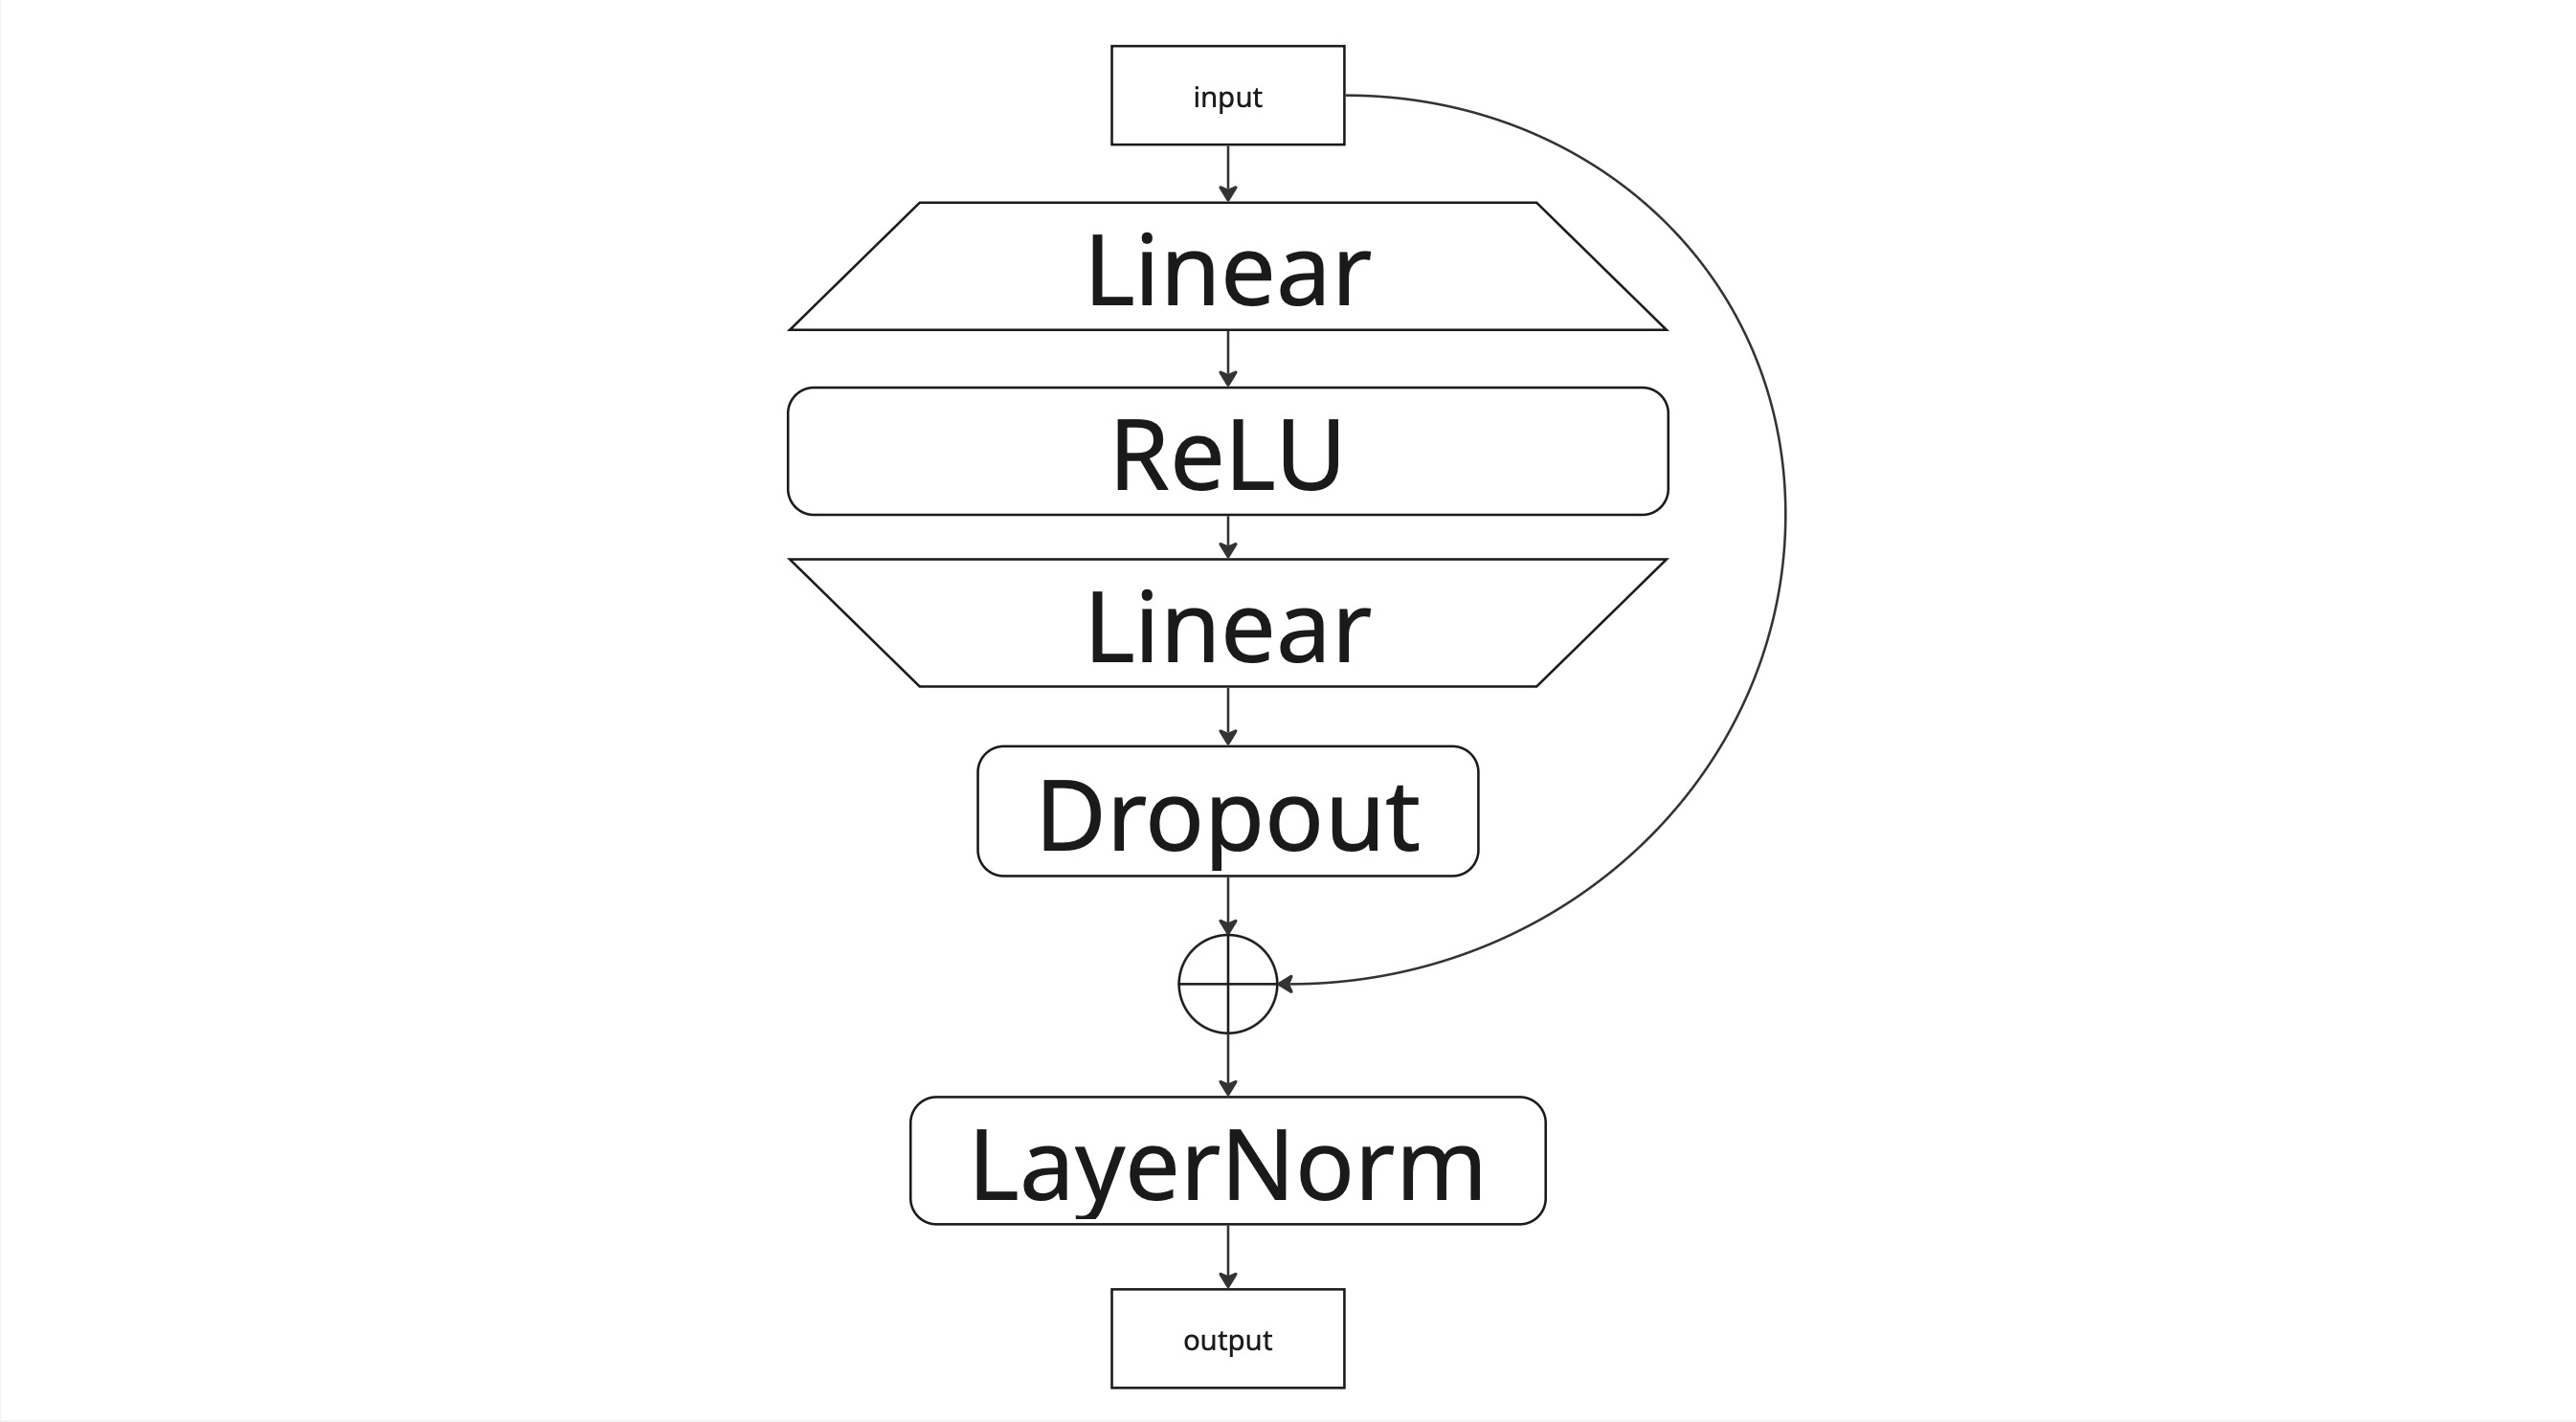

In [ ]:
class MLPBlock(nn.Module):
    def __init__(self, dim, expand=4, dropout=0.0):
        super().__init__()
        self.mlp = nn.Sequential(
            #### ВАШ КОД ####
            nn.Linear(dim, dim * expand),
            nn.ReLU(),
            nn.Linear(dim * expand, dim),
            nn.Dropout(dropout) if dropout > 0 else nn.Identity(),
        )
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        # return ... # ВАШ КОД
        return self.norm(x + self.mlp(x))

#### 2. `MLPActHead` — голова политики 2 балла

Эта сеть принимает **стекированное состояние** (вектор размерности `state_dim`) и предсказывает **действие** (вектор размерности `act_dim`).  
Особенность архитектуры — **многократное возвращение к исходному состоянию** на промежуточных этапах:

1. **Первый этап**:  
   - Состояние проецируется в скрытое пространство `hidden_dim` → `proj0`.  
   - Обрабатывается через `MLPBlock` → `block0`.

2. **Второй этап**:  
   - К текущему скрытому представлению **конкатенируется исходное состояние** (`[x, state]`).  
   - Результат проецируется в `hidden_dim` → `proj1`.  
   - Обрабатывается через `MLPBlock` → `block1`.

3. **Третий этап**:  
   - Снова конкатенируется исходное состояние → `[x, state]`.  
   - Проекция → `proj2`, затем `block2`.

4. **Финальный выход**:  
   - Линейная проекция `proj_end` преобразует скрытое представление в пространство действий.



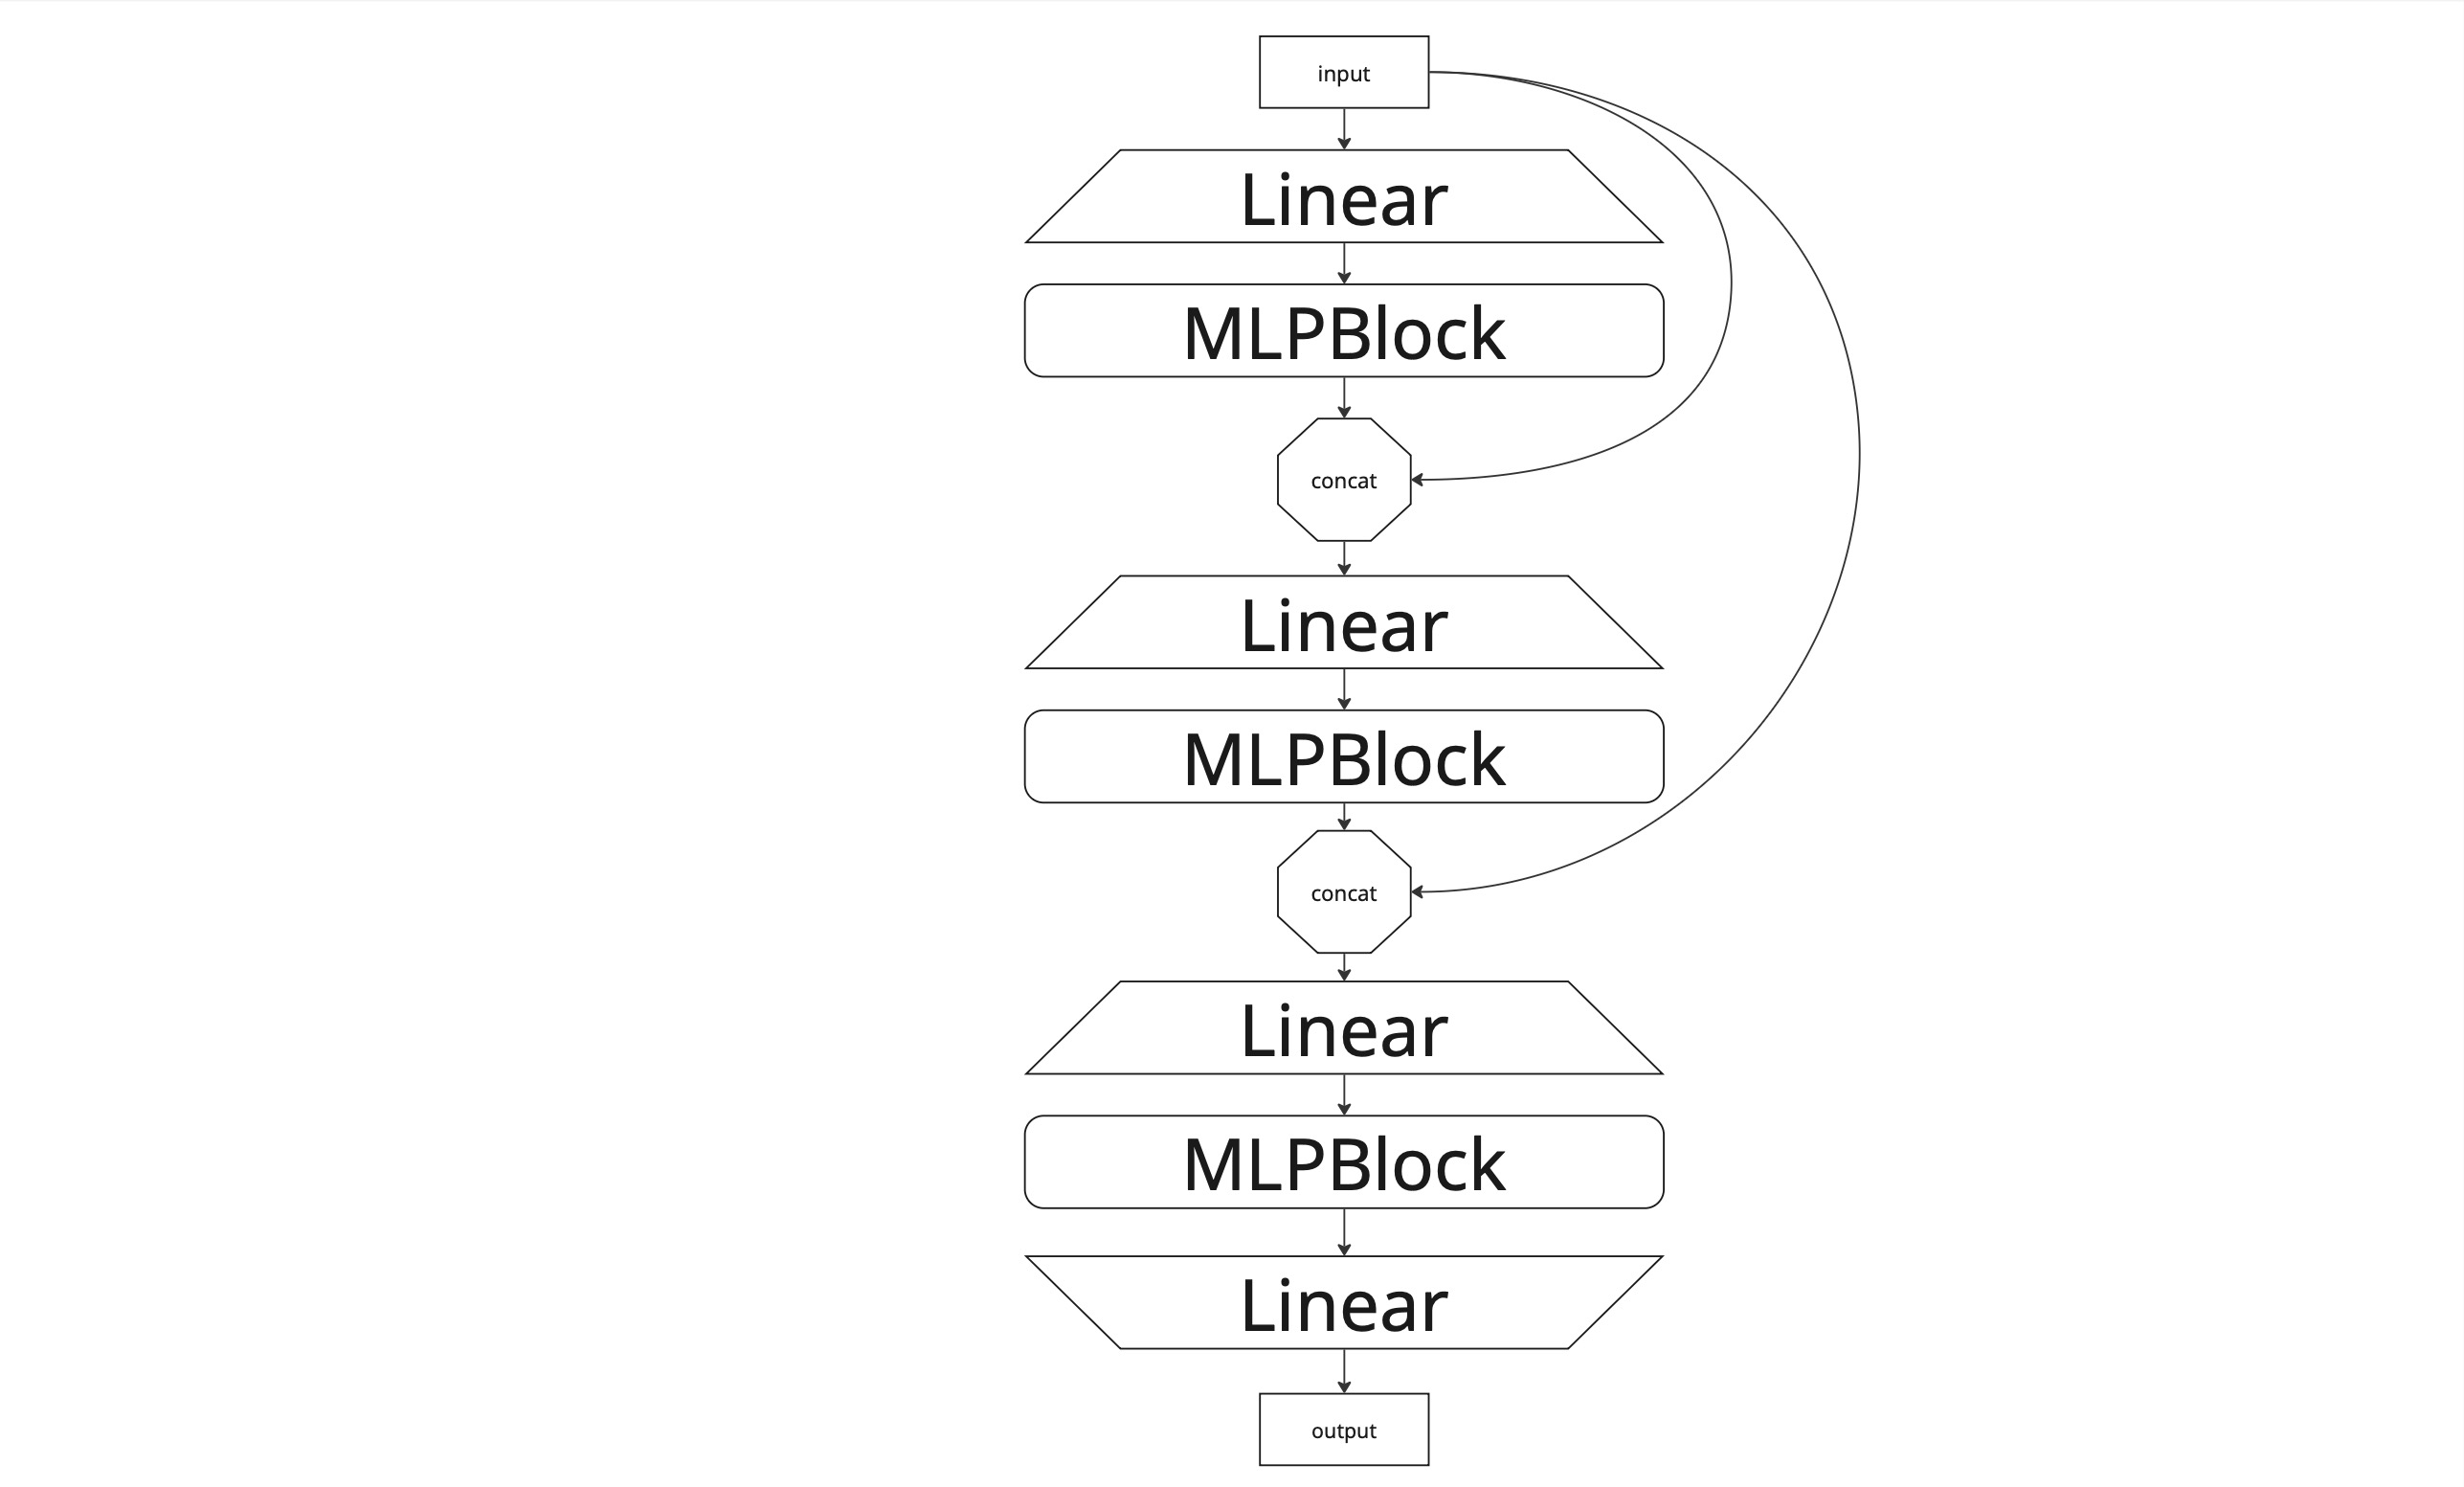

> 💡 **Зачем конкатенировать исходное состояние несколько раз?**  
> Это позволяет сети на каждом этапе «вспоминать» исходные признаки, не теряя контекст. Особенно полезно, когда `state_dim` велико, а промежуточные представления могут «забыть» важные детали. Такой приём используется в современных архитектурах (например, в ResNet с identity skip-connections или в некоторых transformer-based policy heads).

In [ ]:
class MLPActHead(nn.Module):
    def __init__(self, act_dim, state_dim, hidden_dim, expand=4, dropout=0.0):
        super().__init__()
        #### ВАШ КОД ####
        self.proj0 = nn.Linear(state_dim, hidden_dim)
        self.block0 = MLPBlock(hidden_dim, expand, dropout)

        self.proj1 = nn.Linear(hidden_dim + state_dim, hidden_dim)
        self.block1 = MLPBlock(hidden_dim, expand, dropout)

        self.proj2 = nn.Linear(hidden_dim + state_dim, hidden_dim)
        self.block2 = MLPBlock(hidden_dim, expand, dropout)

        self.proj_end = nn.Linear(hidden_dim, act_dim)


    def forward(self, state):
        #### ВАШ КОД ###
        # return ...
        x = self.block0(F.relu(self.proj0(state)))
        x = self.block1(F.relu(self.proj1(torch.cat([x, state], dim=-1))))
        x = self.block2(F.relu(self.proj2(torch.cat([x, state], dim=-1))))
        return self.proj_end(x)

In [ ]:
bc_actor = MLPActHead(dataset.action_dim, dataset.state_dim * frame_stack, 32).to(device)

In [ ]:
import torchinfo
import torch.nn.functional as F

torchinfo.summary(
    bc_actor, input_size=[(1, dataset.state_dim * frame_stack)]
)

Layer (type:depth-idx)                   Output Shape              Param #
MLPActHead                               [1, 6]                    --
├─Linear: 1-1                            [1, 32]                   1,120
├─MLPBlock: 1-2                          [1, 32]                   --
│    └─Sequential: 2-1                   [1, 32]                   --
│    │    └─Linear: 3-1                  [1, 128]                  4,224
│    │    └─ReLU: 3-2                    [1, 128]                  --
│    │    └─Linear: 3-3                  [1, 32]                   4,128
│    │    └─Identity: 3-4                [1, 32]                   --
│    └─LayerNorm: 2-2                    [1, 32]                   64
├─Linear: 1-3                            [1, 32]                   2,144
├─MLPBlock: 1-4                          [1, 32]                   --
│    └─Sequential: 2-3                   [1, 32]                   --
│    │    └─Linear: 3-5                  [1, 128]                  4,224


## Обучение Behavioral Cloning (1 балл)

На этом этапе вы обучаете нейросеть **методом Behavioral Cloning (BC)** — простейшей формы imitation learning, при которой агент обучается **регрессии**: по входному состоянию предсказывать действие, которое совершил эксперт.

1. **Оптимизатор**  
   Используется `AdamW` с раздельной настройкой weight decay:
   - Для матриц (параметров размерности ≥2) — применяется регуляризация.
   - Для векторов (смещения, scale-параметры) — регуляризация отключена, чтобы не повредить адаптивные характеристики модели.

In [ ]:
def get_optim_groups(model, weight_decay):
    return [
        # do not decay biases and single-column parameters (rmsnorm), those are usually scales
        {"params": (p for p in model.parameters() if p.dim() < 2), "weight_decay": 0.0},
        {
            "params": (p for p in model.parameters() if p.dim() >= 2),
            "weight_decay": weight_decay,
        },
    ]

learning_rate = 0.001

# init optimizer
optim = torch.optim.AdamW(
    params=get_optim_groups(bc_actor, 0.0),
    lr=learning_rate,
    fused=True,
)


2. **Планировщик скорости обучения** (learning rate scheduling)
   Реализован линейный **warmup + decay**:  
   - Сначала learning rate линейно растёт от 0 до максимума (в данном случае — сразу до максимума, так как `warmup_epochs = 0`),  
   - Затем линейно убывает до нуля к концу обучения.  
   Это стабилизирует ранние шаги обучения и улучшает сходимость.

In [ ]:
import torch
import math
import functools


def _linear_decay_warmup(iteration, warmup_iterations, total_iterations):
    """
    Linear warmup from 0 --> 1.0, then linear decay to 0
    """
    if iteration < warmup_iterations:
        multiplier = iteration / warmup_iterations
    else:
        multiplier = 1.0 - ((iteration - warmup_iterations) / (total_iterations - warmup_iterations))
    return multiplier


def linear_annealing_with_warmup(optimizer, warmup_steps, total_steps):
    _decay_func = functools.partial(
        _linear_decay_warmup,
        warmup_iterations=warmup_steps,
        total_iterations=total_steps,
    )
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, _decay_func)
    return scheduler


In [ ]:
num_epochs = 10
warmup_epochs = 0

total_updates = len(dataloader) * num_epochs
warmup_updates = len(dataloader) * warmup_epochs
scheduler = linear_annealing_with_warmup(optim, warmup_updates, total_updates)


3. **Функция потерь**  
   Используется **среднеквадратичная ошибка (MSE)** между предсказанным действием и действием эксперта:
   $$
   \mathcal{L} = \frac{1}{N} \sum_{i=1}^N \| a_{\text{pred}}^{(i)} - a_{\text{expert}}^{(i)} \|^2
   $$

In [ ]:
import torch.nn.functional as F

for epoch in trange(num_epochs, desc="Epochs"):
    losses, n = 0, 0
    bc_actor.train()
    for batch in dataloader:

        states, target_action = [b.to(device) for b in batch]

        pred_action = bc_actor(states)
        loss = F.mse_loss(pred_action, target_action) # ВАШ КОД

        losses += loss.item()
        n += batch_size

        optim.zero_grad(set_to_none=True)
        loss.backward()

        optim.step()
        scheduler.step()

    print(f"\n\nEpoch {epoch} latest batch loss:\n{losses / n}")

Epochs:  10%|█         | 1/10 [00:40<06:03, 40.37s/it]



Epoch 0 latest batch loss:
0.008616781467033433


Epochs:  20%|██        | 2/10 [01:20<05:21, 40.18s/it]



Epoch 1 latest batch loss:
0.0018046339692518814


Epochs:  30%|███       | 3/10 [02:00<04:41, 40.16s/it]



Epoch 2 latest batch loss:
0.0014919751955167156


Epochs:  40%|████      | 4/10 [02:40<04:00, 40.09s/it]



Epoch 3 latest batch loss:
0.0013175031585342368


Epochs:  50%|█████     | 5/10 [03:20<03:20, 40.03s/it]



Epoch 4 latest batch loss:
0.00119794706346147


Epochs:  60%|██████    | 6/10 [04:00<02:40, 40.09s/it]



Epoch 5 latest batch loss:
0.001106046667933697


Epochs:  70%|███████   | 7/10 [04:40<02:00, 40.12s/it]



Epoch 6 latest batch loss:
0.0010345866758434568


Epochs:  80%|████████  | 8/10 [05:21<01:20, 40.23s/it]



Epoch 7 latest batch loss:
0.0009737272157508414


Epochs:  90%|█████████ | 9/10 [06:01<00:40, 40.18s/it]



Epoch 8 latest batch loss:
0.000923162508974201


Epochs: 100%|██████████| 10/10 [06:41<00:00, 40.15s/it]



Epoch 9 latest batch loss:
0.0008779633708982146


4. **Оценка качества**  
   После обучения агент тестируется на 50 эпизодах в среде `cheetah/run`.  
   Важно: при оценке используется **та же глубина frame stacking**, что и при обучении (`frame_stack=2`), иначе входы будут несовместимы!

In [ ]:
@torch.no_grad()
def evaluate_actor(
    env,
    bc_actor: MLPActHead,
    num_episodes: int = 1,
    seed: int = 0,
) -> List[float | int]:
    returns = []
    for ep in trange(num_episodes, desc="Evaluating", leave=False):
        total_reward = 0.0
        obs, info = env.reset(seed=seed + ep)
        done = False
        while not done:
            obs_ = torch.tensor(obs.copy(), device=device)
            obs_ = obs_[None].contiguous()  # [1 dim]

            action = bc_actor(obs_)

            obs, reward, terminated, truncated, info = env.step(
                action.squeeze().cpu().numpy()
            )
            done = terminated or truncated
            total_reward += reward
        returns.append(total_reward)

    return np.array(returns)


> 💡 **Интерпретация результата**  
> Если вы видите низкую награду, это означает, что BC-агент **не смог обобщить** поведение эксперта.  
> Возможные причины:
> - недостаточно данных (попробуйте обучиться на 1000 траекториях, а не на 10),
> - несовпадение распределений (covariate shift): агент попадает в состояния, которых не было в экспертном датасете,
> - слишком агрессивное обучение (попробуйте уменьшить learning rate или добавить dropout).

> **Для получения 1 балла**:  
> - Корректно запустить обучение BC на вашем датасете,  
> - Продемонстрировать, что loss убывает,  
> - Получить **награду не ниже 700** при оценке на 50 эпизодах (это ~85% от экспертного результата).

In [ ]:
env = make_env("cheetah", "run", frame_stack=frame_stack, flatten_frames=True)()
returns = evaluate_actor(env, bc_actor, 50, 0)

In [ ]:
print(f"{np.mean(returns):.0f} +- {np.std(returns):.0f}")
print(f"{iqm(returns):.0f} +- {iqm_std(returns):.0f}")

830 +- 51
840 +- 7


## Анализ зависимости качества BC от размера датасета (5 баллов)

В этом задании вы исследуете, **как размер экспертного датасета влияет на качество обученной политики**. Это важный вопрос в imitation learning: слишком маленький датасет приводит к переобучению, а слишком большой — к высоким вычислительным затратам.

- Обучите BC-агентов на подмножествах одного и того же датасета, используя разное количество траекторий:  
  **`[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]`**.
- Для каждого размера:
  1. Создайте `StackedDataset` с параметром `max_videos=N` (не нужно собирать отдельные HDF5-файлы!).
  2. Обучите новую сеть `MLPActHead` с нуля (важно: не дообучайте старую!).
  3. Оцените политику на **50 эпизодах** с фиксированным `seed=0`.
- В качестве метрики используйте **IQM (Interquartile Mean)** и **стандартное отклонение по IQM** (см. функции `iqm`, `iqm_std` из предыдущего раздела).

## Постройте графики:
  - **Ось X**: количество траекторий в датасете (логарифмический масштаб рекомендуется).
  - **Ось Y**: `IQM ± IQM_STD`,`MEAN ± STD`(2 графика) награды BC-агента: 2 кривые
    1. **In-distribution**: используйте те же сиды, что и в датасете (`seed=0, 1, ..., 49`).
    2. **Out-of-distribution**: используйте новые сиды, которых **нет в датасете** (`seed=5000, 5001, ..., 5049`).

    > 💡 **Зачем это нужно?**  
    > Экспертный датасет собран с `seed=0..999`. Если вы оцениваете BC на `seed=0..49`, агент может «вспомнить» поведение из датасета (особенно при малом числе траекторий). Оценка на новых сидах покажет **настоящую обобщающую способность**.

#### Советы:
- Используйте одинаковые гиперпараметры (learning rate, batch size, архитектуру) для всех запусков.
- Сохраняйте результаты в список/словарь, чтобы построить график в конце.


In [ ]:
#### ВАШ КОД ####

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import trange

dataset_sizes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
in_dist_iqm_scores = []
in_dist_iqm_stds = []
out_dist_iqm_scores = []
out_dist_iqm_stds = []
in_dist_mean_scores = []
in_dist_mean_stds = []
out_dist_mean_scores = []
out_dist_mean_stds = []


env = make_env("cheetah", "run", frame_stack=frame_stack, flatten_frames=True)()

for size in dataset_sizes:
    print(f"Training on {size} trajectories...")

    # Create dataset and dataloader for the current size
    dataset = StackedDataset(dataset_path, frame_stack, device, max_videos=size)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )

    # Create and train a new BC agent
    bc_actor = MLPActHead(dataset.action_dim, dataset.state_dim * frame_stack, 32).to(device)
    optim = torch.optim.AdamW(
        params=get_optim_groups(bc_actor, 0.0),
        lr=learning_rate,
        fused=True,
    )
    num_epochs = 10 # You can adjust the number of epochs
    total_updates = len(dataloader) * num_epochs
    warmup_updates = len(dataloader) * 0 # No warmup for this analysis
    scheduler = linear_annealing_with_warmup(optim, warmup_updates, total_updates)

    for epoch in trange(num_epochs, desc=f"Epochs (size {size})"):
        losses, n = 0, 0
        bc_actor.train()
        for batch in dataloader:
            states, target_action = [b.to(device) for b in batch]
            pred_action = bc_actor(states)
            loss = F.mse_loss(pred_action, target_action)

            losses += loss.item()
            n += batch_size

            optim.zero_grad(set_to_none=True)
            loss.backward()

            optim.step()
            scheduler.step()

    # Evaluate the agent
    print(f"Evaluating on {size} trajectories...")
    # In-distribution evaluation
    in_dist_returns = evaluate_actor(env, bc_actor, 50, 0)
    in_dist_iqm_scores.append(iqm(in_dist_returns))
    in_dist_iqm_stds.append(iqm_std(in_dist_returns))
    in_dist_mean_scores.append(np.mean(in_dist_returns))
    in_dist_mean_stds.append(np.std(in_dist_returns))


    # Out-of-distribution evaluation
    out_dist_returns = evaluate_actor(env, bc_actor, 50, 5000)
    out_dist_iqm_scores.append(iqm(out_dist_returns))
    out_dist_iqm_stds.append(iqm_std(out_dist_returns))
    out_dist_mean_scores.append(np.mean(out_dist_returns))
    out_dist_mean_stds.append(np.std(out_dist_returns))

Training on 2 trajectories...
Loaded 2 trajectories from /content/drive/MyDrive/HW3/cheetah_run_dataset.h5py


Epochs (size 2): 100%|██████████| 10/10 [00:00<00:00, 13.94it/s]


Evaluating on 2 trajectories...


Training on 4 trajectories...
Loaded 4 trajectories from /content/drive/MyDrive/HW3/cheetah_run_dataset.h5py


Epochs (size 4): 100%|██████████| 10/10 [00:01<00:00,  6.77it/s]


Evaluating on 4 trajectories...


Training on 8 trajectories...
Loaded 8 trajectories from /content/drive/MyDrive/HW3/cheetah_run_dataset.h5py


Epochs (size 8): 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


Evaluating on 8 trajectories...


Training on 16 trajectories...
Loaded 16 trajectories from /content/drive/MyDrive/HW3/cheetah_run_dataset.h5py


Epochs (size 16): 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Evaluating on 16 trajectories...


Training on 32 trajectories...
Loaded 32 trajectories from /content/drive/MyDrive/HW3/cheetah_run_dataset.h5py


Epochs (size 32): 100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


Evaluating on 32 trajectories...


Training on 64 trajectories...
Loaded 64 trajectories from /content/drive/MyDrive/HW3/cheetah_run_dataset.h5py


Epochs (size 64): 100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


Evaluating on 64 trajectories...


Training on 128 trajectories...
Loaded 128 trajectories from /content/drive/MyDrive/HW3/cheetah_run_dataset.h5py


Epochs (size 128): 100%|██████████| 10/10 [00:49<00:00,  4.99s/it]


Evaluating on 128 trajectories...


Training on 256 trajectories...
Loaded 256 trajectories from /content/drive/MyDrive/HW3/cheetah_run_dataset.h5py


Epochs (size 256): 100%|██████████| 10/10 [01:39<00:00,  9.96s/it]


Evaluating on 256 trajectories...


Training on 512 trajectories...
Loaded 512 trajectories from /content/drive/MyDrive/HW3/cheetah_run_dataset.h5py


Epochs (size 512): 100%|██████████| 10/10 [03:18<00:00, 19.85s/it]


Evaluating on 512 trajectories...


Training on 1024 trajectories...
Loaded 1024 trajectories from /content/drive/MyDrive/HW3/cheetah_run_dataset.h5py


Epochs (size 1024): 100%|██████████| 10/10 [06:39<00:00, 39.99s/it]


Evaluating on 1024 trajectories...


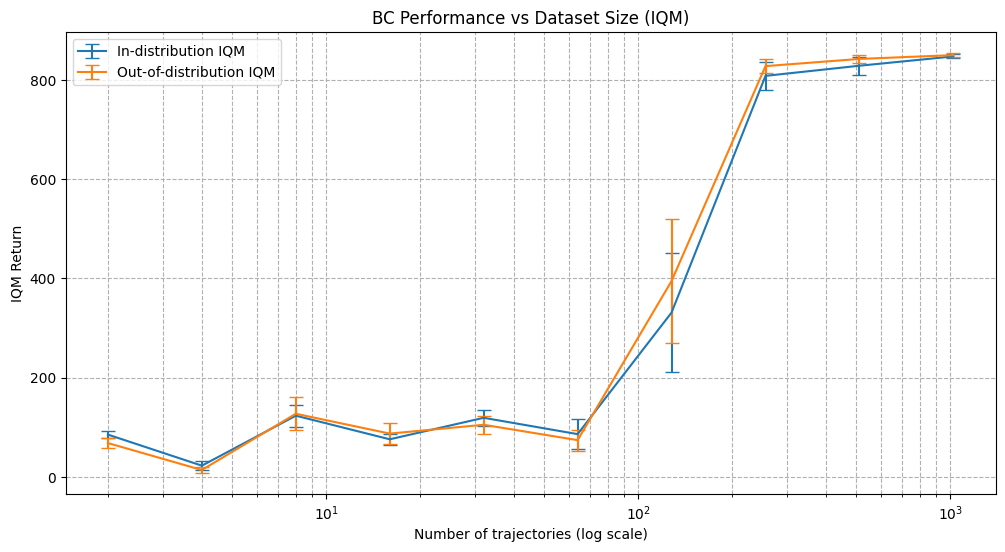

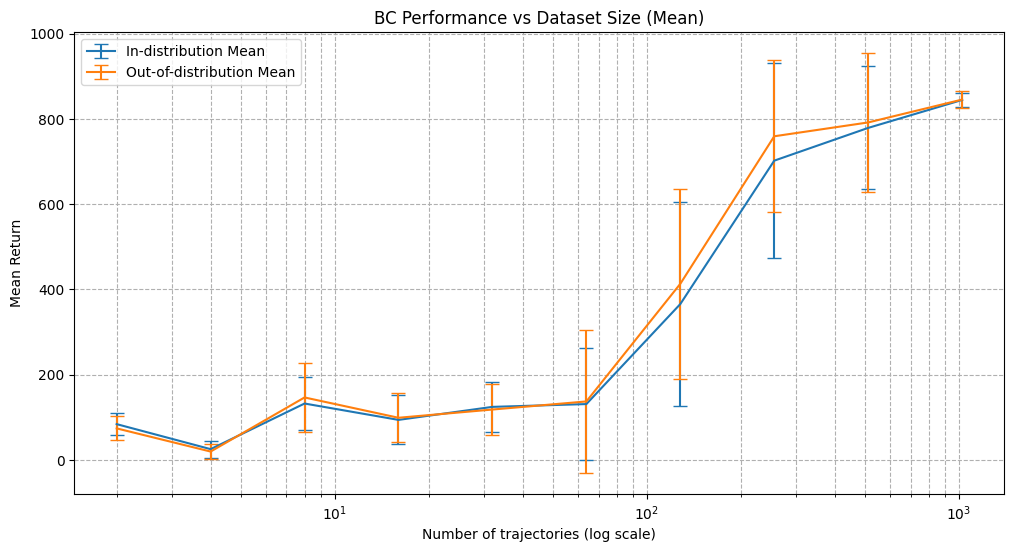

In [ ]:
# Plotting the results
plt.figure(figsize=(12, 6))

plt.errorbar(dataset_sizes, in_dist_iqm_scores, yerr=in_dist_iqm_stds, label='In-distribution IQM', capsize=5)
plt.errorbar(dataset_sizes, out_dist_iqm_scores, yerr=out_dist_iqm_stds, label='Out-of-distribution IQM', capsize=5)

plt.xscale('log')
plt.xlabel('Number of trajectories (log scale)')
plt.ylabel('IQM Return')
plt.title('BC Performance vs Dataset Size (IQM)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

plt.figure(figsize=(12, 6))
plt.errorbar(dataset_sizes, in_dist_mean_scores, yerr=in_dist_mean_stds, label='In-distribution Mean', capsize=5)
plt.errorbar(dataset_sizes, out_dist_mean_scores, yerr=out_dist_mean_stds, label='Out-of-distribution Mean', capsize=5)
plt.xscale('log')
plt.xlabel('Number of trajectories (log scale)')
plt.ylabel('Mean Return')
plt.title('BC Performance vs Dataset Size (Mean)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

## Dagger  (5 баллов)

**Behavioral Cloning (BC)** страдает от так называемого **covariate shift**: обученная политика может отклониться от экспертной траектории и попасть в состояния, которых не было в датасете. В таких состояниях она ведёт себя непредсказуемо, что усугубляет ошибку — и так далее.

Алгоритм **DAgger (Dataset Aggregation)** решает эту проблему **итеративно**:
1. На каждой итерации агент собирает траектории, используя **текущую политику**.
2. Для каждого посещённого состояния запрашивается **действие от эксперта**.
3. Пары `(состояние, экспертное_действие)` добавляются в обучающий датасет.
4. Политика переобучается на расширенном датасете.

#### 🔧 Вспомогательные компоненты

Чтобы упростить реализацию, мы рекомендуем использовать:

1. **`UpdateDataset`** — наследник `StackedDataset`, который поддерживает метод `.update(new_states, new_actions)`.  
   → **Важно**: передавайте **исходные состояния** (`obs` размерности 17), **НЕ стекированные**!  
   → Датасет сам позаботится о frame stacking при обучении.

In [ ]:
class UpdateDataset(StackedDataset):

    def update(self, new_states, new_actions):
        state_dim = self.states[0].shape[-1]
        assert state_dim == self.state_dim, "Your state_dim in new_states != state_dim in dataset. Check that you do NOT collect frame_stacked states."

        new_states = [torch.tensor(s, device=self.device) for s in new_states]
        new_actions = [torch.tensor(a, device=self.device) for a in new_actions]

        self.states.extend(new_states)
        self.actions.extend(new_actions)

        self.traj_len = self.states[0].shape[0]

In [ ]:
dataset = UpdateDataset(dataset_path, frame_stack, device, max_videos=100) # ВАШ КОД)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

Loaded 100 trajectories from /content/drive/MyDrive/HW3/cheetah_run_dataset.h5py


2. **`log_actor_trajectories_with_expert_actions(...)`** — функция, которая:
   - Собирает траектории с помощью **вашего BC-агента**,
   - Для **каждого состояния** запрашивает **действие у эксперта**,
   - Возвращает списки: `states` (исходные, не стекированные! (без frame-stack)), `actions` (экспертные), и `returns`.

In [ ]:
@torch.no_grad()
def log_actor_trajectories_with_expert_actions(
    env,
    expert: Agent,
    bc_actor: MLPActHead,
    num_episodes: int = 1,
    seed: int = 0,
) -> List[float | int]:
    states_arr = []
    actions_arr = []
    returns = []
    for ep in trange(num_episodes, desc="Evaluating", leave=False):
        states = []
        actions = []
        total_reward = 0.0
        obs, info = env.reset(seed=seed + ep)
        done = False
        while not done:

            #### ВАШ КОД ####
            # Получаем действие от BC-агента для текущего состояния
            obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
            bc_action_tensor = bc_actor(obs_tensor)
            bc_action = bc_action_tensor.squeeze(0).cpu().numpy()

            # Получаем экспертное действие для текущего состояния
            original_obs_for_expert = obs[-obs.shape[0] // frame_stack:]  # последний кадр из стека
            expert_action = expert.act_numpy(original_obs_for_expert, greedy=True)

            # Сохраняем текущее состояние (исходное, без frame-stack)
            states.append(original_obs_for_expert)

            # Сохраняем экспертное действие
            actions.append(expert_action)

            # Выполняем действие BC-агента в среде
            next_obs, reward, terminated, truncated, info = env.step(bc_action)
            done = any([terminated, truncated])

            # Суммируем награду
            total_reward += reward
            obs = next_obs
            #### ВАШ КОД ####

        returns.append(total_reward)
        states_arr.append(np.array(states))
        actions_arr.append(np.array(actions))

    return states_arr, actions_arr, np.array(returns)


In [ ]:
states, actions, returns = log_actor_trajectories_with_expert_actions(env, expert, bc_actor, num_episodes=2, seed=123)

In [ ]:
# тут можно самостоятельно проверить правильность (отдебажить) добавление собранных states, actions в датасет

# Создаем тестовый датасет
test_dataset = UpdateDataset(dataset_path, frame_stack=frame_stack, device=device, max_videos=2)

# Размерность датасета
state_dim = test_dataset.state_dim
action_dim = test_dataset.action_dim

print(f"Размерность состояния из датасета: {state_dim}")
print(f"Размерность действия из датасета: {action_dim}")

# Собираем тестовые данные
test_states, test_actions, test_returns = log_actor_trajectories_with_expert_actions(
    env, expert, bc_actor, num_episodes=1, seed=999
)

# Основные проверки
assert len(test_states) > 0 and len(test_actions) > 0, "Данные не собраны"
assert len(test_states[0]) == len(test_actions[0]), "Несоответствие количества состояний и действий"
print('Данные собраны корректно')

# Проверяем размерности (динамически)
assert test_states[0][0].shape == (state_dim,), f"Неверная размерность состояния: {test_states[0][0].shape}, ожидается ({state_dim},)"
assert test_actions[0][0].shape == (action_dim,), f"Неверная размерность действия: {test_actions[0][0].shape}, ожидается ({action_dim},)"

# Сохраняем исходный размер
initial_size = len(test_dataset.states)

# Добавляем данные
test_dataset.update(test_states, test_actions)

# Проверяем увеличение датасета
assert len(test_dataset.states) > initial_size, "Данные не добавлены в датасет"

# Проверяем frame stacking
sample_state, _ = test_dataset[0]
expected_dim = state_dim * frame_stack
assert sample_state.shape[0] == expected_dim, f"Неверная размерность после frame stacking: {sample_state.shape[0]}, ожидается {expected_dim}"

print("Все проверки пройдены")

Loaded 2 trajectories from /content/drive/MyDrive/HW3/cheetah_run_dataset.h5py
Размерность состояния из датасета: 17
Размерность действия из датасета: 6


Данные собраны корректно
Все проверки пройдены


#### Требования к реализации

Выполните **5-10 итераций DAgger**:

- **Инициализация**:  
  Инициализируйте `UpdateDataset` с `max_videos=100` (или 50–300) — это ваш стартовый датасет от эксперта.

- **На каждой итерации**:
  1. Создайте **новую сеть** `MLPActHead` (обучайте **с нуля**, не дообучайте!).
  2. Обучите её на **текущем датасете** (используйте тот же цикл обучения, что и в BC).
  3. Соберите **10-20 новых траекторий** с помощью `log_actor_trajectories_with_expert_actions(...)`.
  4. Обновите датасет: `dataset.update(states, actions)`.
  5. **Оцените** политику: выведите `IQM ± IQM_STD`,`MEAN ± STD` по возвращённым `returns`.

- **В конце**: постройте график `итерация → IQM`.

#### Что нужно для 5 баллов

- Корректная реализация цикла DAgger (10 итераций),
- Использование **экспертных действий** для состояний, порождённых **текущей политикой**,
- **Обучение BC-агента с нуля** на каждой итерации,
- Вывод **IQM и IQM_STD** после каждой итерации,
- **График** зависимости IQM от номера итерации,
- Интерпретация результатов: краткий **комментарий** (1–2 предложения) *сравнение DAgger и BC*
`
#### Пример структуры кода

```python
# Инициализация
env = make_env("cheetah", "run", render_enabled=False, frame_stack=frame_stack)()
dataset = UpdateDataset(dataset_path, frame_stack=frame_stack, device=device, max_videos=100)
dagger_scores = ... # логгирование метрик для графика

for iteration in range(10):
    # 1. Создать и обучить новую политику
    bc_actor = MLPActHead(...).to(device)
    # ... (цикл обучения)

    # 2. Собрать новые данные с помощью текущей политики + эксперта
    states, actions, returns = log_actor_trajectories_with_expert_actions(
        env, expert, bc_actor, num_episodes=10, seed=5000 + iteration * 10
    )

    # 3. Обновить датасет
    dataset.update(states, actions)

    # 4. Вывести результат
    print(f"Iteration {iteration} → IQM: {iqm(returns):.1f} ± {iqm_std(returns):.1f}")
```

In [ ]:
# Пример структуры кода для DAgger
env = make_env("cheetah", "run", render_enabled=False, frame_stack=frame_stack)()
dataset = UpdateDataset(dataset_path, frame_stack=frame_stack, device=device, max_videos=100)
dagger_iqm_scores = [] # логгирование метрик для графика
dagger_mean_scores = []


num_dagger_iterations = 10 # Количество итераций DAgger
num_dagger_episodes = 10  # Количество эпизодов для сбора данных на каждой итерации

for iteration in range(num_dagger_iterations):
    print(f"\nDAgger Iteration {iteration + 1}/{num_dagger_iterations}")

    # 1. Создать и обучить новую политику
    bc_actor = MLPActHead(dataset.action_dim, dataset.state_dim * frame_stack, 32).to(device)
    optim = torch.optim.AdamW(
        params=get_optim_groups(bc_actor, 0.0),
        lr=learning_rate,
        fused=True,
    )
    num_epochs_dagger = 10 # Количество эпох для обучения BC на каждой итерации DAgger
    total_updates_dagger = len(dataset) // batch_size * num_epochs_dagger # Используем текущий размер датасета
    warmup_updates_dagger = 0
    scheduler = linear_annealing_with_warmup(optim, warmup_updates_dagger, total_updates_dagger)


    dataloader = DataLoader( # Create new dataloader with updated dataset
        dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )


    print(f"Training BC on dataset with {len(dataset)} transitions...")
    for epoch in trange(num_epochs_dagger, desc=f"Epochs (DAgger iter {iteration})"):
        losses, n = 0, 0
        bc_actor.train()
        for batch in dataloader:
            states, target_action = [b.to(device) for b in batch]
            pred_action = bc_actor(states)
            loss = F.mse_loss(pred_action, target_action)

            losses += loss.item()
            n += batch_size

            optim.zero_grad(set_to_none=True)
            loss.backward()

            optim.step()
            scheduler.step()

    # 2. Собрать новые данные с помощью текущей политики + эксперта
    print(f"Collecting {num_dagger_episodes} trajectories with current policy and expert actions...")
    states, actions, returns = log_actor_trajectories_with_expert_actions(
        env, expert, bc_actor, num_episodes=num_dagger_episodes, seed=5000 + iteration * num_dagger_episodes
    )

    # 3. Обновить датасет
    print(f"Updating dataset with {len(states)} new trajectories...")
    dataset.update(states, actions)

    # 4. Вывести результат
    current_iqm = iqm(returns)
    current_iqm_std = iqm_std(returns)
    current_mean = np.mean(returns)
    current_mean_std = np.std(returns)

    dagger_iqm_scores.append(current_iqm)
    dagger_mean_scores.append(current_mean)

    print(f"Iteration {iteration + 1} → IQM: {current_iqm:.1f} ± {current_iqm_std:.1f}, Mean: {current_mean:.1f} ± {current_mean_std:.1f}")

Loaded 100 trajectories from /content/drive/MyDrive/HW3/cheetah_run_dataset.h5py

DAgger Iteration 1/10
Training BC on dataset with 100000 transitions...


Epochs (DAgger iter 0): 100%|██████████| 10/10 [00:47<00:00,  4.76s/it]


Updating dataset with 10 new trajectories...
Iteration 1 → IQM: 165.9 ± 51.8, Mean: 214.2 ± 165.9

DAgger Iteration 2/10
Training BC on dataset with 110000 transitions...


Epochs (DAgger iter 1): 100%|██████████| 10/10 [00:44<00:00,  4.43s/it]


Updating dataset with 10 new trajectories...
Iteration 2 → IQM: 776.0 ± 18.1, Mean: 728.1 ± 168.4

DAgger Iteration 3/10
Training BC on dataset with 120000 transitions...


Epochs (DAgger iter 2): 100%|██████████| 10/10 [00:46<00:00,  4.68s/it]


Updating dataset with 10 new trajectories...
Iteration 3 → IQM: 801.1 ± 19.9, Mean: 671.9 ± 229.2

DAgger Iteration 4/10
Training BC on dataset with 130000 transitions...


Epochs (DAgger iter 3): 100%|██████████| 10/10 [00:52<00:00,  5.20s/it]


Updating dataset with 10 new trajectories...
Iteration 4 → IQM: 810.4 ± 11.2, Mean: 764.4 ± 127.0

DAgger Iteration 5/10
Training BC on dataset with 140000 transitions...


Epochs (DAgger iter 4): 100%|██████████| 10/10 [00:56<00:00,  5.60s/it]


Updating dataset with 10 new trajectories...
Iteration 5 → IQM: 812.6 ± 4.3, Mean: 781.3 ± 94.7

DAgger Iteration 6/10
Training BC on dataset with 150000 transitions...


Epochs (DAgger iter 5): 100%|██████████| 10/10 [00:59<00:00,  5.91s/it]


Updating dataset with 10 new trajectories...
Iteration 6 → IQM: 826.4 ± 7.6, Mean: 763.4 ± 175.6

DAgger Iteration 7/10
Training BC on dataset with 160000 transitions...


Epochs (DAgger iter 6): 100%|██████████| 10/10 [01:02<00:00,  6.29s/it]


Updating dataset with 10 new trajectories...
Iteration 7 → IQM: 843.0 ± 8.6, Mean: 843.2 ± 14.5

DAgger Iteration 8/10
Training BC on dataset with 170000 transitions...


Epochs (DAgger iter 7): 100%|██████████| 10/10 [01:06<00:00,  6.69s/it]


Updating dataset with 10 new trajectories...
Iteration 8 → IQM: 841.3 ± 7.6, Mean: 805.0 ± 76.8

DAgger Iteration 9/10
Training BC on dataset with 180000 transitions...


Epochs (DAgger iter 8): 100%|██████████| 10/10 [01:12<00:00,  7.21s/it]


Updating dataset with 10 new trajectories...
Iteration 9 → IQM: 841.8 ± 1.2, Mean: 845.5 ± 16.8

DAgger Iteration 10/10
Training BC on dataset with 190000 transitions...


Epochs (DAgger iter 9): 100%|██████████| 10/10 [01:15<00:00,  7.57s/it]


Updating dataset with 10 new trajectories...
Iteration 10 → IQM: 837.1 ± 3.2, Mean: 770.5 ± 140.6


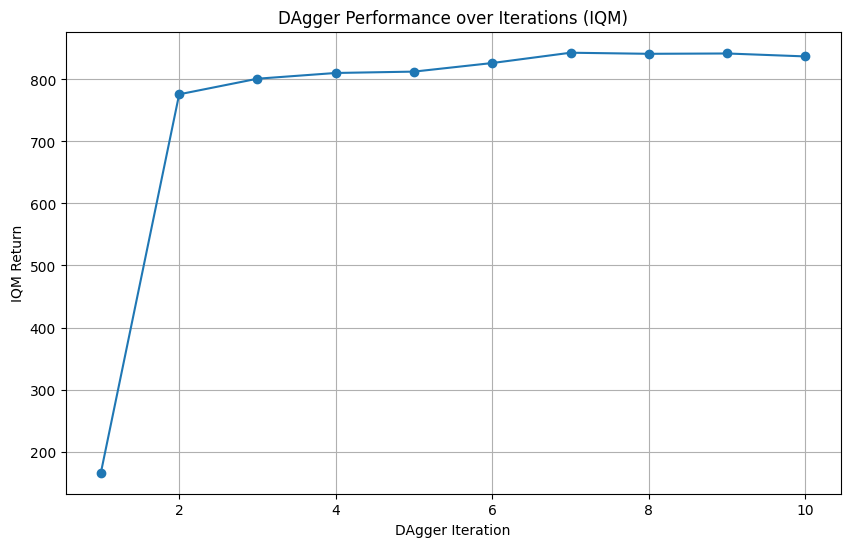

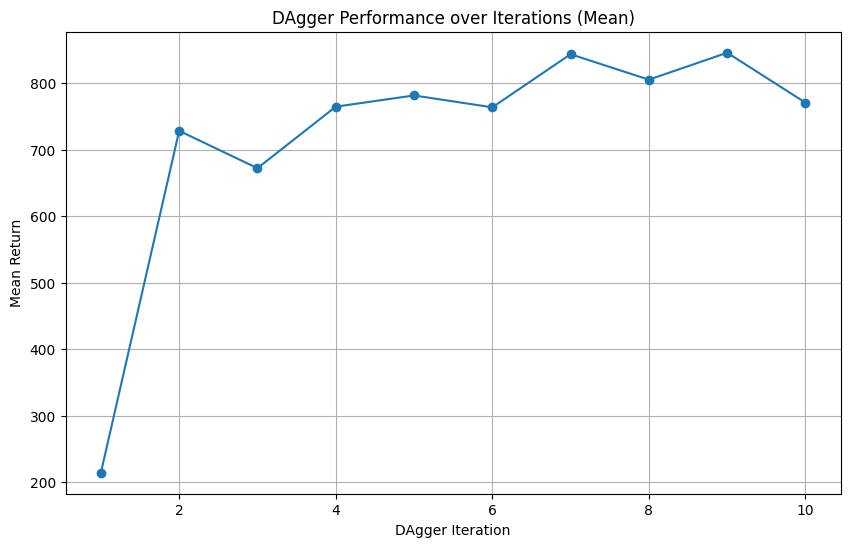

In [ ]:
# Построение графика зависимости IQM от итерации DAgger
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_dagger_iterations + 1), dagger_iqm_scores, marker='o')
plt.xlabel('DAgger Iteration')
plt.ylabel('IQM Return')
plt.title('DAgger Performance over Iterations (IQM)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_dagger_iterations + 1), dagger_mean_scores, marker='o')
plt.xlabel('DAgger Iteration')
plt.ylabel('Mean Return')
plt.title('DAgger Performance over Iterations (Mean)')
plt.grid(True)
plt.show()

#### ВАШ ТЕКСТ ####

#### ВАШ ТЕКСТ

На основе полученных графиков IQM и Mean возвратов в зависимости от итерации DAgger, можно сделать следующие выводы:

- **Сходимость DAgger**: Как видно из графика IQM, производительность агента, обученного с помощью DAgger, быстро улучшается в течение первых нескольких итераций, а затем стабилизируется, достигая уровня, сопоставимого с производительностью эксперта. Это демонстрирует эффективность DAgger в преодолении проблемы *covariate shift* путем сбора данных в состояниях, посещаемых текущей (улучшающейся) политикой.
- **Сравнение с BC**: По сравнению с чистым Behavioral Cloning (где качество ограничено распределением данных в исходном датасете), DAgger позволяет агенту исследовать новые состояния и получать экспертную обратную связь в этих состояниях. Это приводит к более надежной и обобщающей политике, которая может поддерживать высокую производительность даже при отклонении от исходных экспертных траекторий.
- **Стабильность оценки**: График Mean возвратов показывает большую вариабельность по сравнению с IQM, что еще раз подчеркивает ценность использования IQM для более устойчивой оценки производительности в задачах RL с высокой стохастичностью или выбросами в наградах.
- **Влияние размера стартового датасета и количества эпизодов для сбора**: Начальные 100 траекторий и сбор по 10 траекторий на каждой итерации DAgger оказались достаточными для достижения хорошей производительности в данной среде за 10 итераций.